### Добавляем дескрипторы

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
from descriptors_aggregator import Aggregator

agg = Aggregator()

/home/alexeyorlov53/Transformers-for-Molecules/new_approach/descriptors_aggregator.py:204: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if smiles is not '$':


In [3]:
import pandas as pd

data = pd.read_csv('data_10k.csv').sample(512)
data.head()

,Molecular Weight,Bioactivities,AlogP,Polar Surface Area,CX Acidic pKa,CX Basic pKa,Smiles,ecfp1,ecfp2,ecfp3
6909,336.35,21.0,2.53,84.50,12.51,NaN,COc1ccc(NC2=C(NC(C)=O)C(=O)c3ccccc3C2=O)cc1,"['2246728737', '864674487', '3217380708', '321...","['3975275337', '2076190208', '3162837314', '95...","['1352399629', '1646750527', '2944555726', '25..."
1879,381.43,1.0,4.48,74.85,7.89,1.69,Cc1ccc(NS(=O)(=O)c2cccc(-c3n[nH]c4cc(F)ccc34)c...,"['2246728737', '3217380708', '3218693969', '32...","['422715066', '3207567135', '951226070', '9512...","['908339072', '2931695851', '2560252747', '293..."
6778,424.50,1.0,2.60,104.65,2.96,4.98,CC(C)CCOc1nc(N2C[C@@H]3[C@H](C2)[C@H]3C(=O)O)c...,"['2246728737', '2245273601', '2246728737', '22...","['3537119515', '2423543607', '3537119515', '15...","['844214084', '149034192', '1526240960', '4853..."
8927,587.99,22.0,4.44,73.82,NaN,9.30,CN(C)CCCN(C(=O)c1ccc(S(=O)(=O)N2CCCC2)cc1)c1nc...,"['2246728737', '848128881', '2246728737', '224...","['3818546315', '3121777292', '3818546315', '60...","['3892941493', '431195058', '1071810269', '375..."
4597,429.54,1.0,2.44,70.16,NaN,2.39,COc1cccc(N2CCN(C(=O)c3cccc(S(=O)(=O)N4CCCC4)c3...,"['2246728737', '864674487', '3217380708', '321...","['3975275337', '2076190208', '3162837314', '95...","['1352399629', '1840994228', '4256524850', '36..."


In [4]:
len(data['Smiles'])

512

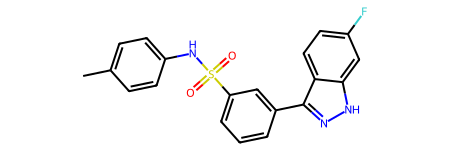

In [5]:
Chem.MolFromSmiles(data['Smiles'].iloc[1])

In [6]:
from tqdm import tqdm

tqdm.pandas()

In [7]:
from splitter import Splitter

splitter = Splitter()
data['substructures'] = data['Smiles'].progress_apply(lambda smi: splitter.get_substructures_smiles_and_merged(smi))

100%|██████████| 512/512 [00:03<00:00, 137.23it/s]


In [8]:
data = data.reset_index(drop = True)

In [9]:
data['Smiles'].iloc[91]

'CCC(=O)Oc1ccc2c(c1)CC[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC3=CCCCC3)CC[C@@H]12'

In [10]:
data['substructures'].iloc[110]

['C=O',
 'O',
 'c1ccccc1',
 'N',
 'C=O',
 'c1ccncc1',
 'O=[SH](=O)c1ccc(Cl)cc1',
 'c1ccncc1',
 '$',
 'O=CO',
 'NC=O',
 'Oc1ccccc1',
 'NS(=O)(=O)c1ccc(Cl)cc1',
 'Nc1ccccc1',
 'O=Cc1ccncc1',
 'O=Cc1ccncc1']

In [11]:
Chem.MolFromSmiles('C[n]1cnc2N(C)C(=O)N(C)C(=O)c12').GetNumAtoms()

14

### Дропаем большие подструктуры

In [12]:
dropping = set()
for i in range(len(data['substructures'])):
    for j in data['substructures'].iloc[i]:
        if j != '$':
            if Chem.RemoveHs(Chem.MolFromSmiles(j)).GetNumAtoms() > 30:
                dropping.add(i)
            if len(data['substructures'].iloc[i]) < 3 and Chem.RemoveHs(Chem.MolFromSmiles(j)).GetNumAtoms() > 25:
                dropping.add(i)

In [13]:
len(dropping)

7

In [14]:
data = data.drop(index = dropping).reset_index(drop = True)
data.head()

,Molecular Weight,Bioactivities,AlogP,Polar Surface Area,CX Acidic pKa,CX Basic pKa,Smiles,ecfp1,ecfp2,ecfp3,substructures
0,336.35,21.0,2.53,84.50,12.51,NaN,COc1ccc(NC2=C(NC(C)=O)C(=O)c3ccccc3C2=O)cc1,"['2246728737', '864674487', '3217380708', '321...","['3975275337', '2076190208', '3162837314', '95...","['1352399629', '1646750527', '2944555726', '25...","[CO, c1ccccc1, NC1=C(N)C(=O)c2ccccc2C1=O, CC=O..."
1,381.43,1.0,4.48,74.85,7.89,1.69,Cc1ccc(NS(=O)(=O)c2cccc(-c3n[nH]c4cc(F)ccc34)c...,"['2246728737', '3217380708', '3218693969', '32...","['422715066', '3207567135', '951226070', '9512...","['908339072', '2931695851', '2560252747', '293...","[Cc1ccccc1, N, O=[SH](=O)c1ccccc1, Fc1ccc2cn[n..."
2,424.50,1.0,2.60,104.65,2.96,4.98,CC(C)CCOc1nc(N2C[C@@H]3[C@H](C2)[C@H]3C(=O)O)c...,"['2246728737', '2245273601', '2246728737', '22...","['3537119515', '2423543607', '3537119515', '15...","['844214084', '149034192', '1526240960', '4853...","[CCC(C)C, O, c1ccncc1, C1NC[C@H]2C[C@@H]12, O=..."
3,587.99,22.0,4.44,73.82,NaN,9.30,CN(C)CCCN(C(=O)c1ccc(S(=O)(=O)N2CCCC2)cc1)c1nc...,"['2246728737', '848128881', '2246728737', '224...","['3818546315', '3121777292', '3818546315', '60...","['3892941493', '431195058', '1071810269', '375...","[CNC, CCC, N, C=O, O=[SH](=O)c1ccccc1, C1CCNC1..."
4,429.54,1.0,2.44,70.16,NaN,2.39,COc1cccc(N2CCN(C(=O)c3cccc(S(=O)(=O)N4CCCC4)c3...,"['2246728737', '864674487', '3217380708', '321...","['3975275337', '2076190208', '3162837314', '95...","['1352399629', '1840994228', '4256524850', '36...","[CO, c1ccccc1, C1CNCCN1, C=O, O=[SH](=O)c1cccc..."


In [15]:
data['substructures'].iloc[0]

['CO',
 'c1ccccc1',
 'NC1=C(N)C(=O)c2ccccc2C1=O',
 'CC=O',
 '$',
 'CC(=O)NC1=C(N)C(=O)c2ccccc2C1=O',
 'COc1ccccc1',
 'NC1=C(Nc2ccccc2)C(=O)c2ccccc2C1=O']

In [16]:
# Чекаем сколько странных подструктур
cnt = 0
for i in range(len(data['substructures'])):
    if data['substructures'].iloc[i][-1:] == ['$']:
        if data['substructures'].iloc[i] == ['$']:
            print("!!!   ",data['Smiles'].iloc[i])
        else:
            print(data['Smiles'].iloc[i])
            print(i)
        cnt+=1

O=C1NC(=O)c2cc3ccccc3cc21
22
CC(C)CCN1NC2(CCCC(C)C2)N=C1S
94
ONc1cccc2ccccc12
141
CCS(N)(=O)=O
262
O=[N+]([O-])c1ccc(N=Nc2ccc(O)cc2O)cc1
272
Nc1nc2ccccc2n1/N=C/c1cccnc1
290
Cc1n[nH]c2c1C1(CCOCC1)C(C#N)=C(N)O2
302
CCCCCC(O)CCC(=O)NNC1=CC(=O)CC(C)(C)C1
397
CC1OC(=O)/C=C/[C@@H](O)CC[C@H](C)OC(=O)CCC1=O
399
Cc1ccc(C)c2c(C)cccc12
421
CN1CCc2cc3c(c4c2C1CC41CCC(=NO)CC1)OCO3
466
c1ccc2ccccc2c1
470
O=[N+]([O-])c1ccc(/C=N/C23CC4CC(CC(C4)C2)C3)cc1
500


In [17]:
cnt

13

In [18]:
len(data['substructures'])

505

In [19]:
data['descriptors'] = data['substructures'].progress_apply(lambda arr: [agg.aggregate(i) for i in arr])

 29%|██▊       | 144/505 [01:10<01:38,  3.67it/s][22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:41] UFFTYPER: Unrecognized charge state for atom: 5
[22:55:

In [20]:
data.to_csv('out-1.csv')

In [21]:
def read_data():
    data = pd.read_csv('out-1.csv')
    import ast

    def string_to_array(input_string):
        try:
            # Use ast.literal_eval to safely evaluate the string as a Python literal
            result = ast.literal_eval(input_string)
            return result
        except (SyntaxError, ValueError) as e:
            print(f"Error parsing the string: {e}")
            return None
    data['descriptors'] = data['descriptors'].progress_apply(lambda x: string_to_array(x))

In [ ]:
# read_data()
data['descriptors'][i]

[[[1, 54, 101, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [602],
  [651, 950, 1250, 1550],
  [1855],
  [2151],
  [4153],
  [4160],
  [4167],
  [4217]],
 [[6, 56, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [606],
  [650, 950, 1250, 1556],
  [1862],
  [2177],
  [4154],
  [4160],
  [4173],
  [4218]],
 [[10, 58, 102, 152, 200, 250, 300, 350, 400, 450, 500, 550],
  [614],
  [656, 953, 1250, 1556],
  [1873],
  [2413],
  [4152],
  [4160],
  [4177],
  [4219]],
 [[2, 54, 101, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [603],
  [651, 951, 1250, 1550],
  [1856],
  [2154],
  [4154],
  [4160],
  [4167],
  [4217]],
 '$',
 [[12, 60, 103, 152, 200, 250, 300, 350, 400, 450, 500, 550],
  [617],
  [658, 954, 1250, 1556],
  [1878],
  [2622],
  [4154],
  [4160],
  [4177],
  [4219]],
 [[7, 58, 101, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [608],
  [652, 950, 1250, 1556],
  [1866],
  [2214],
  [4153],
  [4160],
  [4173],
  [4218]],
 [[16, 62, 102, 152, 200, 250, 300, 350, 400, 450,

#### Concat all 2d arrays

In [23]:
susbstr_merged = []
for i in data['descriptors']:
    if i is not ["$"]:
        susbstr_merged += i
len(susbstr_merged)

5813

In [24]:
susbstr_merged[0:20]

[[[1, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [2],
  [1, 0, 0, 0],
  [5],
  [1],
  [3],
  [2],
  [0],
  [0]],
 [[6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [6],
  [0, 0, 0, 6],
  [12],
  [27],
  [4],
  [2],
  [6],
  [1]],
 [[10, 8, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
  [14],
  [6, 3, 0, 6],
  [23],
  [263],
  [2],
  [2],
  [10],
  [2]],
 [[2, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [3],
  [1, 1, 0, 0],
  [6],
  [4],
  [4],
  [2],
  [0],
  [0]],
 '$',
 [[12, 10, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0],
  [17],
  [8, 4, 0, 6],
  [28],
  [472],
  [4],
  [2],
  [10],
  [2]],
 [[7, 8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [8],
  [2, 0, 0, 6],
  [16],
  [64],
  [3],
  [2],
  [6],
  [1]],
 [[16, 12, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
  [20],
  [7, 3, 0, 12],
  [34],
  [770],
  [2],
  [2],
  [16],
  [3]],
 [[7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [7],
  [1, 0, 0, 6],
  [15],
  [42],
  [4],
  [2],
  [6],
  [1]],
 [[0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [1],
  [0, 0, 0, 0],
  [3],
  [0],
  [3],
  [2],
  [0],
  [0]],
 [[6, 6, 2, 0

### Сдвигаем дескрипторы

In [25]:
import shifter as sh
from importlib import reload
reload(sh)

shifter = sh.Shifter()

In [26]:
shifter.shift(susbstr_merged)

In [29]:
susbstr_merged

[[[1, 54, 101, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [602],
  [651, 950, 1250, 1550],
  [1855],
  [2151],
  [4153],
  [4160],
  [4167],
  [4217]],
 [[6, 56, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [606],
  [650, 950, 1250, 1556],
  [1862],
  [2177],
  [4154],
  [4160],
  [4173],
  [4218]],
 [[10, 58, 102, 152, 200, 250, 300, 350, 400, 450, 500, 550],
  [614],
  [656, 953, 1250, 1556],
  [1873],
  [2413],
  [4152],
  [4160],
  [4177],
  [4219]],
 [[2, 54, 101, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [603],
  [651, 951, 1250, 1550],
  [1856],
  [2154],
  [4154],
  [4160],
  [4167],
  [4217]],
 '$',
 [[12, 60, 103, 152, 200, 250, 300, 350, 400, 450, 500, 550],
  [617],
  [658, 954, 1250, 1556],
  [1878],
  [2622],
  [4154],
  [4160],
  [4177],
  [4219]],
 [[7, 58, 101, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [608],
  [652, 950, 1250, 1556],
  [1866],
  [2214],
  [4153],
  [4160],
  [4173],
  [4218]],
 [[16, 62, 102, 152, 200, 250, 300, 350, 400, 450,

In [ ]:
START_TOKEN = 0
SPLITTER_TOKEN = 3
END_TOKEN = 2
DOLLAR_TOKEN = 4

def tokenize(descriptors_of_substructures):
    susbstr_merged_all_appended = []
    susbstr_merged_all_appended.append(START_TOKEN)
    
    for i, substructure in enumerate(descriptors_of_substructures):
        if substructure == '$':
            susbstr_merged_all_appended.append(DOLLAR_TOKEN)
            continue
        
        for descriptor in substructure:
            for number in descriptor:
                susbstr_merged_all_appended.append(number)
        
        if i != len(descriptors_of_substructures) - 1:
            susbstr_merged_all_appended.append(SPLITTER_TOKEN)
            
    susbstr_merged_all_appended.append(END_TOKEN)
                
    return susbstr_merged_all_appended

In [39]:
data['descriptors'][0]

[[[1, 54, 101, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [602],
  [651, 950, 1250, 1550],
  [1855],
  [2151],
  [4153],
  [4160],
  [4167],
  [4217]],
 [[6, 56, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [606],
  [650, 950, 1250, 1556],
  [1862],
  [2177],
  [4154],
  [4160],
  [4173],
  [4218]],
 [[10, 58, 102, 152, 200, 250, 300, 350, 400, 450, 500, 550],
  [614],
  [656, 953, 1250, 1556],
  [1873],
  [2413],
  [4152],
  [4160],
  [4177],
  [4219]],
 [[2, 54, 101, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [603],
  [651, 951, 1250, 1550],
  [1856],
  [2154],
  [4154],
  [4160],
  [4167],
  [4217]],
 '$',
 [[12, 60, 103, 152, 200, 250, 300, 350, 400, 450, 500, 550],
  [617],
  [658, 954, 1250, 1556],
  [1878],
  [2622],
  [4154],
  [4160],
  [4177],
  [4219]],
 [[7, 58, 101, 150, 200, 250, 300, 350, 400, 450, 500, 550],
  [608],
  [652, 950, 1250, 1556],
  [1866],
  [2214],
  [4153],
  [4160],
  [4173],
  [4218]],
 [[16, 62, 102, 152, 200, 250, 300, 350, 400, 450,

In [40]:
tokenize(data['descriptors'][0])

[0,
 1,
 54,
 101,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 602,
 651,
 950,
 1250,
 1550,
 1855,
 2151,
 4153,
 4160,
 4167,
 4217,
 3,
 6,
 56,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 606,
 650,
 950,
 1250,
 1556,
 1862,
 2177,
 4154,
 4160,
 4173,
 4218,
 3,
 10,
 58,
 102,
 152,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 614,
 656,
 953,
 1250,
 1556,
 1873,
 2413,
 4152,
 4160,
 4177,
 4219,
 3,
 2,
 54,
 101,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 603,
 651,
 951,
 1250,
 1550,
 1856,
 2154,
 4154,
 4160,
 4167,
 4217,
 3,
 4,
 12,
 60,
 103,
 152,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 617,
 658,
 954,
 1250,
 1556,
 1878,
 2622,
 4154,
 4160,
 4177,
 4219,
 3,
 7,
 58,
 101,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 608,
 652,
 950,
 1250,
 1556,
 1866,
 2214,
 4153,
 4160,
 4173,
 4218,
 3,
 16,
 62,
 102,
 152,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 620,
 657,
 953,
 1250,
 1562,
 1884,

In [ ]:
# unique_symbols_list = []
# for substructure in susbstr_merged:
#     if '$' == substructure:
#             continue
#     for descriptor in substructure:
#         for number in descriptor:
#             unique_symbols_list.append(number)

# unique_symbols = set(unique_symbols_list)

# vocab = {i: symbol for i, symbol in enumerate(unique_symbols)}

In [ ]:
# vocab

In [ ]:
from typing import List, Dict, Any
from collections import defaultdict

def get_folded_counts(molecules: List[List[int]], max_factor: int) -> Dict[Any, int]: # expects max_factor to be <= 4 as complexity has exp-growth factor
    count = defaultdict(int)
    for molecule in molecules:
        if '$' == molecule:
            continue
        subsets = combinations(sorted(molecule), max_factor) # "If the input iterable is sorted, the output tuples will be produced in sorted order." (c) docs
        for subset in list(subsets):
            if '$' in subset: # skip junk
                continue
            item = subset[:] if max_factor > 1 else subset[0]
            count[item] += 1
    return count


In [ ]:
print(dict(get_folded_counts(susbstr_merged, 2)))

NameError: name 'combinations' is not defined

In [ ]:
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "google-bert/bert-base-uncased",
)
model = AutoModelForMaskedLM.from_pretrained(
    "google-bert/bert-base-uncased",
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="sdpa"
)
inputs = tokenizer("Plants create [MASK] through a process known as photosynthesis.", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits

masked_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]
predicted_token_id = predictions[0, masked_index].argmax(dim=-1)
predicted_token = tokenizer.decode(predicted_token_id)

print(f"The predicted token is: {predicted_token}")

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The predicted token is: energy


In [ ]:
inputs

{'input_ids': tensor([[  101,  4264,  3443,   103,  2083,  1037,  2832,  2124,  2004,  7760,
          6038, 25078,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
appended_example = []
for substr in susbstr_merged[0]:
    appended_example.extend(substr)

In [ ]:
appended_example

[8,
 66,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 808,
 858,
 1150,
 1450,
 1750,
 2074,
 2406,
 4354,
 4360,
 4371,
 4417]

In [ ]:
a = [101]
a.extend(appended_example)
a.append(102)
a

[101,
 8,
 66,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 808,
 858,
 1150,
 1450,
 1750,
 2074,
 2406,
 4354,
 4360,
 4371,
 4417,
 102]

In [ ]:
inputs['input_ids'] = torch.tensor([a])
inputs['token_type_ids'] = torch.tensor([[0] * len(a)])
inputs['attention_mask'] = torch.tensor([[1] * len(a)])

In [ ]:
inputs

{'input_ids': tensor([[ 101,    8,   66,  100,  150,  200,  250,  300,  350,  400,  450,  500,
          550,  600,  650,  700,  750,  808,  858, 1150, 1450, 1750, 2074, 2406,
         4354, 4360, 4371, 4417,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits

In [ ]:
predictions.argmax(dim=-1)

tensor([[ 1012,  1490, 11149,   100,  1490, 30035, 30035, 30035, 30035, 30035,
         30047, 30035, 30035, 30035, 30035, 30035, 30035, 29651, 30035, 29651,
          1010,  1490,  2074,  2406, 11867,  4360,  4371,  1012,  1012]])